## 1. Setup and Data Loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    precision_recall_fscore_support, roc_auc_score
)
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

NumPy: 1.26.4
Pandas: 2.2.3
XGBoost: 2.1.4
TensorFlow: 2.18.0
GPU Available: False


In [4]:
# Load L2 order book data
data_path = "../data/orderbook_data/eth_orderbook_coinbase_combined.csv"
df = pd.read_csv(data_path, parse_dates=['timestamp'])

print("="*80)
print("DATA INSPECTION")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

# Infer sampling frequency
time_diffs = df['timestamp'].diff().dropna()
median_freq = time_diffs.median()
print(f"\nMedian sampling frequency: {median_freq}")
print(f"Mean sampling frequency: {time_diffs.mean()}")

# Identify L2 structure
bid_price_cols = [c for c in df.columns if c.startswith('bid_price_')]
ask_price_cols = [c for c in df.columns if c.startswith('ask_price_')]
bid_vol_cols = [c for c in df.columns if c.startswith('bid_vol_')]
ask_vol_cols = [c for c in df.columns if c.startswith('ask_vol_')]

num_levels = len(bid_price_cols)
print(f"\nL2 Order Book Structure:")
print(f"  Number of levels: {num_levels}")
print(f"  Bid price columns: {bid_price_cols[:3]} ...")
print(f"  Bid volume columns: {bid_vol_cols[:3]} ...")
print(f"  Ask price columns: {ask_price_cols[:3]} ...")
print(f"  Ask volume columns: {ask_vol_cols[:3]} ...")

print(f"\n✓ Data loaded: {len(df):,} samples, {num_levels} price levels")

DATA INSPECTION
Shape: (13000, 41)
Date range: 2025-11-18 01:09:15.259076 to 2025-11-27 03:27:56.101553
Duration: 9 days 02:18:40.842477

Median sampling frequency: 0 days 00:01:00.338484
Mean sampling frequency: 0 days 00:01:00.460100198

L2 Order Book Structure:
  Number of levels: 10
  Bid price columns: ['bid_price_1', 'bid_price_2', 'bid_price_3'] ...
  Bid volume columns: ['bid_vol_1', 'bid_vol_2', 'bid_vol_3'] ...
  Ask price columns: ['ask_price_1', 'ask_price_2', 'ask_price_3'] ...
  Ask volume columns: ['ask_vol_1', 'ask_vol_2', 'ask_vol_3'] ...

✓ Data loaded: 13,000 samples, 10 price levels


## 2. Define Midprice and Labels

Label definition:
- Compute midprice: `mid_t = (best_bid + best_ask) / 2`
- Compute return over horizon H: `r_t = (mid_{t+H} - mid_t) / mid_t`
- Assign labels:
  - `2` (UP) if `r_t > eps`
  - `0` (DOWN) if `r_t < -eps`
  - `1` (FLAT) if `-eps <= r_t <= eps`

In [5]:
def make_midprice_direction_labels(midprice: np.ndarray, H: int, eps: float) -> np.ndarray:
    """
    Create ternary labels (DOWN=0, FLAT=1, UP=2) based on future midprice movement.
    
    Args:
        midprice: Array of midprices at each timestep
        H: Horizon in steps (e.g., 10)
        eps: Deadzone threshold as a fraction (e.g., 0.0005 = 0.05%)
    
    Returns:
        labels: Array of shape (len(midprice),) with values 0/1/2, or -1 for invalid
    """
    n = len(midprice)
    labels = np.full(n, -1, dtype=np.int32)  # Initialize as invalid
    
    for t in range(n - H):
        mid_t = midprice[t]
        mid_future = midprice[t + H]
        
        # Compute return
        ret = (mid_future - mid_t) / mid_t
        
        # Assign label
        if ret > eps:
            labels[t] = 2  # UP
        elif ret < -eps:
            labels[t] = 0  # DOWN
        else:
            labels[t] = 1  # FLAT
    
    return labels


# Parameters
HORIZON = 10  # Look 10 steps ahead
DEADZONE = 0.0005  # 0.05% deadzone (filters small noise)

# Compute midprice
df['midprice'] = (df['bid_price_1'] + df['ask_price_1']) / 2

# Create labels
labels = make_midprice_direction_labels(
    df['midprice'].values, 
    H=HORIZON, 
    eps=DEADZONE
)

# Filter out invalid labels (last H rows)
valid_mask = (labels != -1)
df_valid = df[valid_mask].copy()
df_valid['label'] = labels[valid_mask]

print("="*80)
print("LABEL CREATION")
print("="*80)
print(f"Horizon (H): {HORIZON} steps")
print(f"Deadzone (ε): {DEADZONE:.4f} ({DEADZONE*100:.2f}%)")
print(f"\nOriginal samples: {len(df):,}")
print(f"Valid samples: {len(df_valid):,}")
print(f"Removed (insufficient future data): {len(df) - len(df_valid)}")

# Class distribution
class_counts = df_valid['label'].value_counts().sort_index()
print(f"\nClass Distribution:")
print(f"  0 (DOWN):  {class_counts[0]:>6,} ({100*class_counts[0]/len(df_valid):>5.1f}%)")
print(f"  1 (FLAT):  {class_counts[1]:>6,} ({100*class_counts[1]/len(df_valid):>5.1f}%)")
print(f"  2 (UP):    {class_counts[2]:>6,} ({100*class_counts[2]/len(df_valid):>5.1f}%)")

# Check for class imbalance
min_class_pct = class_counts.min() / len(df_valid) * 100
if min_class_pct < 10:
    print(f"\n⚠️ WARNING: Smallest class is only {min_class_pct:.1f}% - consider adjusting H or eps")
else:
    print(f"\n✓ Classes are reasonably balanced (smallest: {min_class_pct:.1f}%)")

LABEL CREATION
Horizon (H): 10 steps
Deadzone (ε): 0.0005 (0.05%)

Original samples: 13,000
Valid samples: 12,990
Removed (insufficient future data): 10

Class Distribution:
  0 (DOWN):   5,625 ( 43.3%)
  1 (FLAT):   1,850 ( 14.2%)
  2 (UP):     5,515 ( 42.5%)

✓ Classes are reasonably balanced (smallest: 14.2%)


## 3. Feature Engineering

Build features from L2 order book that are available at time t (no lookahead).

### Feature Categories:
1. **Price-based**: midprice, spread, spread_bps
2. **Depth/Imbalance**: total bid/ask depth, depth imbalance
3. **Level-wise structure**: relative prices and sizes for each level
4. **Short history**: 5-step changes in midprice, spread, depth

In [6]:
def build_tabular_features_from_l2(df: pd.DataFrame, num_levels: int = 10) -> pd.DataFrame:
    """
    Build tabular features from L2 order book data.
    
    Returns DataFrame with same index as input, containing engineered features.
    """
    features = pd.DataFrame(index=df.index)
    
    # --- 1. Price-based features ---
    features['midprice'] = (df['bid_price_1'] + df['ask_price_1']) / 2
    features['spread'] = df['ask_price_1'] - df['bid_price_1']
    features['spread_bps'] = (features['spread'] / features['midprice']) * 10000
    
    # --- 2. Depth and imbalance ---
    total_bid_depth = sum(df[f'bid_vol_{i}'] for i in range(1, num_levels + 1))
    total_ask_depth = sum(df[f'ask_vol_{i}'] for i in range(1, num_levels + 1))
    
    features['total_bid_depth'] = total_bid_depth
    features['total_ask_depth'] = total_ask_depth
    features['depth_imbalance'] = (
        (total_bid_depth - total_ask_depth) / (total_bid_depth + total_ask_depth + 1e-8)
    )
    
    # --- 3. Level-wise structure ---
    for k in range(1, num_levels + 1):
        # Relative price distance from midprice
        features[f'rel_bid_price_{k}'] = (
            (features['midprice'] - df[f'bid_price_{k}']) / features['midprice']
        )
        features[f'rel_ask_price_{k}'] = (
            (df[f'ask_price_{k}'] - features['midprice']) / features['midprice']
        )
        
        # Log-transformed sizes (handle zeros)
        features[f'log_bid_vol_{k}'] = np.log1p(df[f'bid_vol_{k}'])
        features[f'log_ask_vol_{k}'] = np.log1p(df[f'ask_vol_{k}'])
    
    # --- 4. Short history (5-step changes) ---
    window = 5
    features['midprice_change_5'] = features['midprice'].diff(window).fillna(0)
    features['spread_change_5'] = features['spread'].diff(window).fillna(0)
    features['depth_imb_change_5'] = features['depth_imbalance'].diff(window).fillna(0)
    
    # Momentum indicator
    features['midprice_momentum_5'] = (
        features['midprice'].pct_change(window).fillna(0)
    )
    
    return features


# Build features
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)
print("Building tabular features from L2 order book...")

features_df = build_tabular_features_from_l2(df_valid, num_levels=10)

print(f"\nFeatures created: {len(features_df.columns)}")
print(f"Feature categories:")
print(f"  - Price-based: 3 (midprice, spread, spread_bps)")
print(f"  - Depth/Imbalance: 3 (total_bid_depth, total_ask_depth, depth_imbalance)")
print(f"  - Level-wise (10 levels × 4 per level): 40")
print(f"  - Short history (5-step changes): 4")
print(f"  Total: {len(features_df.columns)} features")

# Check for NaN or Inf
nan_count = features_df.isna().sum().sum()
inf_count = np.isinf(features_df.select_dtypes(include=[np.number]).values).sum()

print(f"\nData quality:")
print(f"  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print(f"  ⚠️ Filling NaN with 0 and clipping Inf values...")
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)

print(f"\n✓ Tabular features ready: shape {features_df.shape}")

FEATURE ENGINEERING
Building tabular features from L2 order book...

Features created: 50
Feature categories:
  - Price-based: 3 (midprice, spread, spread_bps)
  - Depth/Imbalance: 3 (total_bid_depth, total_ask_depth, depth_imbalance)
  - Level-wise (10 levels × 4 per level): 40
  - Short history (5-step changes): 4
  Total: 50 features

Data quality:
  NaN values: 0
  Inf values: 0

✓ Tabular features ready: shape (12990, 50)


## 4. Train-Test Split and Scaling

**Critical**: Time-ordered split (no shuffle) to prevent data leakage.

Split: 70% train, 15% val, 15% test

Scaling: Compute statistics on train set only, apply to val/test.

In [7]:
# Convert to numpy arrays
X = features_df.values
y = df_valid['label'].values

print("="*80)
print("TRAIN-VAL-TEST SPLIT (TIME-ORDERED)")
print("="*80)

# Time-ordered split
n = len(X)
train_end = int(0.70 * n)
val_end = int(0.85 * n)

X_train_raw = X[:train_end]
y_train = y[:train_end]

X_val_raw = X[train_end:val_end]
y_val = y[train_end:val_end]

X_test_raw = X[val_end:]
y_test = y[val_end:]

print(f"Total samples: {n:,}")
print(f"  Train: {len(X_train_raw):,} ({100*len(X_train_raw)/n:.1f}%)")
print(f"  Val:   {len(X_val_raw):,} ({100*len(X_val_raw)/n:.1f}%)")
print(f"  Test:  {len(X_test_raw):,} ({100*len(X_test_raw)/n:.1f}%)")

# Class distribution per split
for split_name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    counts = np.bincount(y_split, minlength=3)
    print(f"\n{split_name} class distribution:")
    print(f"  DOWN (0): {counts[0]:>5,} ({100*counts[0]/len(y_split):>4.1f}%)")
    print(f"  FLAT (1): {counts[1]:>5,} ({100*counts[1]/len(y_split):>4.1f}%)")
    print(f"  UP   (2): {counts[2]:>5,} ({100*counts[2]/len(y_split):>4.1f}%)")

# --- Scaling (train statistics only) ---
print("\n" + "="*80)
print("FEATURE SCALING (TRAIN-SET STATISTICS ONLY)")
print("="*80)

scaler = StandardScaler()
scaler.fit(X_train_raw)

X_train = scaler.transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print(f"Scaling parameters computed on train set:")
print(f"  Feature means range: [{scaler.mean_.min():.4f}, {scaler.mean_.max():.4f}]")
print(f"  Feature stds range:  [{scaler.scale_.min():.4f}, {scaler.scale_.max():.4f}]")

print(f"\nScaled data verification:")
print(f"  Train: mean={X_train.mean():.6f}, std={X_train.std():.6f}")
print(f"  Val:   mean={X_val.mean():.6f}, std={X_val.std():.6f}")
print(f"  Test:  mean={X_test.mean():.6f}, std={X_test.std():.6f}")

print(f"\n✓ Data ready for modeling")

TRAIN-VAL-TEST SPLIT (TIME-ORDERED)
Total samples: 12,990
  Train: 9,093 (70.0%)
  Val:   1,948 (15.0%)
  Test:  1,949 (15.0%)

Train class distribution:
  DOWN (0): 4,081 (44.9%)
  FLAT (1): 1,186 (13.0%)
  UP   (2): 3,826 (42.1%)

Val class distribution:
  DOWN (0):   784 (40.2%)
  FLAT (1):   349 (17.9%)
  UP   (2):   815 (41.8%)

Test class distribution:
  DOWN (0):   760 (39.0%)
  FLAT (1):   315 (16.2%)
  UP   (2):   874 (44.8%)

FEATURE SCALING (TRAIN-SET STATISTICS ONLY)
Scaling parameters computed on train set:
  Feature means range: [-0.1331, 2890.5168]
  Feature stds range:  [0.0000, 136.2615]

Scaled data verification:
  Train: mean=0.000000, std=1.000000
  Val:   mean=-0.026890, std=0.963614
  Test:  mean=-0.071287, std=0.886962

✓ Data ready for modeling


## 5. Baseline Model: Logistic Regression

Simple linear baseline to establish performance floor.

In [8]:
print("="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("="*80)

# Train logistic regression
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle any class imbalance
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Metrics
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print(f"\nAccuracy:")
print(f"  Train: {train_acc_lr:.4f}")
print(f"  Val:   {val_acc_lr:.4f}")
print(f"  Test:  {test_acc_lr:.4f}")

# Baseline comparison (always predict majority class)
majority_class = np.bincount(y_train).argmax()
baseline_acc = (y_test == majority_class).mean()
print(f"\nNaive baseline (always predict class {majority_class}): {baseline_acc:.4f}")
print(f"Improvement over baseline: {(test_acc_lr - baseline_acc):.4f} ({100*(test_acc_lr/baseline_acc - 1):.1f}%)")

# Classification report
print(f"\n{'='*80}")
print("TEST SET EVALUATION")
print("="*80)
print(classification_report(y_test, y_test_pred_lr, 
                          target_names=['DOWN (0)', 'FLAT (1)', 'UP (2)'],
                          digits=4))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print("Confusion Matrix:")
print("             Predicted")
print("           DOWN  FLAT    UP")
print(f"    DOWN {cm_lr[0,0]:>5} {cm_lr[0,1]:>5} {cm_lr[0,2]:>5}")
print(f"    FLAT {cm_lr[1,0]:>5} {cm_lr[1,1]:>5} {cm_lr[1,2]:>5}")
print(f"    UP   {cm_lr[2,0]:>5} {cm_lr[2,1]:>5} {cm_lr[2,2]:>5}")

BASELINE MODEL: LOGISTIC REGRESSION

Accuracy:
  Train: 0.3543
  Val:   0.3214
  Test:  0.3048

Naive baseline (always predict class 0): 0.3899
Improvement over baseline: -0.0852 (-21.8%)

TEST SET EVALUATION
              precision    recall  f1-score   support

    DOWN (0)     0.3907    0.2750    0.3228       760
    FLAT (1)     0.1736    0.5333    0.2619       315
      UP (2)     0.4865    0.2483    0.3288       874

    accuracy                         0.3048      1949
   macro avg     0.3503    0.3522    0.3045      1949
weighted avg     0.3986    0.3048    0.3156      1949

Confusion Matrix:
             Predicted
           DOWN  FLAT    UP
    DOWN   209   381   170
    FLAT    88   168    59
    UP     238   419   217

Accuracy:
  Train: 0.3543
  Val:   0.3214
  Test:  0.3048

Naive baseline (always predict class 0): 0.3899
Improvement over baseline: -0.0852 (-21.8%)

TEST SET EVALUATION
              precision    recall  f1-score   support

    DOWN (0)     0.3907    0.275

## 6. Tree-Based Model: XGBoost

Gradient boosting for non-linear patterns.

In [9]:
print("="*80)
print("TREE-BASED MODEL: XGBOOST")
print("="*80)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    eval_metric='mlogloss',
    early_stopping_rounds=10
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

# Metrics
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"\nAccuracy:")
print(f"  Train: {train_acc_xgb:.4f}")
print(f"  Val:   {val_acc_xgb:.4f}")
print(f"  Test:  {test_acc_xgb:.4f}")

print(f"\nImprovement over baseline: {(test_acc_xgb - baseline_acc):.4f} ({100*(test_acc_xgb/baseline_acc - 1):.1f}%)")
print(f"Improvement over Logistic Regression: {(test_acc_xgb - test_acc_lr):.4f}")

# Classification report
print(f"\n{'='*80}")
print("TEST SET EVALUATION")
print("="*80)
print(classification_report(y_test, y_test_pred_xgb,
                          target_names=['DOWN (0)', 'FLAT (1)', 'UP (2)'],
                          digits=4))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("Confusion Matrix:")
print("             Predicted")
print("           DOWN  FLAT    UP")
print(f"    DOWN {cm_xgb[0,0]:>5} {cm_xgb[0,1]:>5} {cm_xgb[0,2]:>5}")
print(f"    FLAT {cm_xgb[1,0]:>5} {cm_xgb[1,1]:>5} {cm_xgb[1,2]:>5}")
print(f"    UP   {cm_xgb[2,0]:>5} {cm_xgb[2,1]:>5} {cm_xgb[2,2]:>5}")

# Feature importance (top 10)
feature_names = features_df.columns
importance = xgb_model.feature_importances_
top_features_idx = importance.argsort()[-10:][::-1]

print(f"\nTop 10 Most Important Features:")
for i, idx in enumerate(top_features_idx, 1):
    print(f"  {i:>2}. {feature_names[idx]:<30} {importance[idx]:.4f}")

TREE-BASED MODEL: XGBOOST

Accuracy:
  Train: 0.6118
  Val:   0.4071
  Test:  0.4058

Improvement over baseline: 0.0159 (4.1%)
Improvement over Logistic Regression: 0.1011

TEST SET EVALUATION
              precision    recall  f1-score   support

    DOWN (0)     0.3863    0.7395    0.5074       760
    FLAT (1)     1.0000    0.0032    0.0063       315
      UP (2)     0.4625    0.2609    0.3336       874

    accuracy                         0.4058      1949
   macro avg     0.6162    0.3345    0.2825      1949
weighted avg     0.5196    0.4058    0.3485      1949

Confusion Matrix:
             Predicted
           DOWN  FLAT    UP
    DOWN   562     0   198
    FLAT   247     1    67
    UP     646     0   228

Top 10 Most Important Features:
   1. rel_ask_price_1                0.0415
   2. midprice                       0.0286
   3. spread_bps                     0.0282
   4. rel_bid_price_1                0.0273
   5. total_ask_depth                0.0223
   6. midprice_change_5

## 7. Deep Learning Model: LSTM with Sequences

Build sequence features and train a small LSTM model.

In [10]:
def build_sequence_features_from_l2(df: pd.DataFrame, 
                                     features_df: pd.DataFrame,
                                     lookback: int = 60) -> np.ndarray:
    """
    Build sequence features by creating sliding windows.
    
    Args:
        df: Original dataframe with L2 data
        features_df: DataFrame with engineered features
        lookback: Number of timesteps to look back
    
    Returns:
        X_seq: Array of shape (n_samples, lookback, n_features)
        valid_indices: Indices of valid samples (with enough history)
    """
    features = features_df.values
    n_samples = len(features)
    n_features = features.shape[1]
    
    X_seq = []
    valid_indices = []
    
    for i in range(lookback, n_samples):
        X_seq.append(features[i - lookback:i])
        valid_indices.append(i)
    
    return np.array(X_seq), np.array(valid_indices)


# Build sequences
print("="*80)
print("BUILDING SEQUENCE FEATURES FOR LSTM")
print("="*80)

LOOKBACK = 60  # 60 timesteps of history

X_seq, valid_indices = build_sequence_features_from_l2(
    df_valid, features_df, lookback=LOOKBACK
)

# Filter labels and apply same train/val/test split
y_seq = y[valid_indices]

print(f"Sequence shape: {X_seq.shape}")
print(f"  Samples: {X_seq.shape[0]:,}")
print(f"  Lookback: {X_seq.shape[1]} timesteps")
print(f"  Features: {X_seq.shape[2]}")

# Recompute splits on sequence data
n_seq = len(X_seq)
train_end_seq = int(0.70 * n_seq)
val_end_seq = int(0.85 * n_seq)

X_train_seq_raw = X_seq[:train_end_seq]
y_train_seq = y_seq[:train_end_seq]

X_val_seq_raw = X_seq[train_end_seq:val_end_seq]
y_val_seq = y_seq[train_end_seq:val_end_seq]

X_test_seq_raw = X_seq[val_end_seq:]
y_test_seq = y_seq[val_end_seq:]

print(f"\nSequence splits:")
print(f"  Train: {len(X_train_seq_raw):,}")
print(f"  Val:   {len(X_val_seq_raw):,}")
print(f"  Test:  {len(X_test_seq_raw):,}")

# Scale sequences (using same scaler fit on train tabular data)
print("\nScaling sequences...")
X_train_seq = np.array([scaler.transform(seq) for seq in X_train_seq_raw])
X_val_seq = np.array([scaler.transform(seq) for seq in X_val_seq_raw])
X_test_seq = np.array([scaler.transform(seq) for seq in X_test_seq_raw])

print(f"✓ Sequence data ready for LSTM")

BUILDING SEQUENCE FEATURES FOR LSTM
Sequence shape: (12930, 60, 50)
  Samples: 12,930
  Lookback: 60 timesteps
  Features: 50

Sequence splits:
  Train: 9,051
  Val:   1,939
  Test:  1,940

Scaling sequences...
✓ Sequence data ready for LSTM
✓ Sequence data ready for LSTM


In [11]:
print("="*80)
print("DEEP LEARNING MODEL: LSTM")
print("="*80)

# Build LSTM model
T = X_train_seq.shape[1]  # Timesteps
F = X_train_seq.shape[2]  # Features

inputs = layers.Input(shape=(T, F))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(32, return_sequences=False)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation='softmax')(x)  # 3 classes

lstm_model = keras.Model(inputs, outputs)

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
lstm_model.summary()

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'midprice_lstm_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

# Train
print(f"\nTraining LSTM...")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate
train_loss_lstm, train_acc_lstm = lstm_model.evaluate(X_train_seq, y_train_seq, verbose=0)
val_loss_lstm, val_acc_lstm = lstm_model.evaluate(X_val_seq, y_val_seq, verbose=0)
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)

print(f"\n{'='*80}")
print("LSTM RESULTS")
print("="*80)
print(f"Accuracy:")
print(f"  Train: {train_acc_lstm:.4f}")
print(f"  Val:   {val_acc_lstm:.4f}")
print(f"  Test:  {test_acc_lstm:.4f}")

print(f"\nImprovement over baseline: {(test_acc_lstm - baseline_acc):.4f} ({100*(test_acc_lstm/baseline_acc - 1):.1f}%)")
print(f"Improvement over Logistic Regression: {(test_acc_lstm - test_acc_lr):.4f}")
print(f"Improvement over XGBoost: {(test_acc_lstm - test_acc_xgb):.4f}")

# Predictions
y_test_pred_lstm = lstm_model.predict(X_test_seq, verbose=0).argmax(axis=1)

# Classification report
print(f"\n{'='*80}")
print("TEST SET EVALUATION")
print("="*80)
print(classification_report(y_test_seq, y_test_pred_lstm,
                          target_names=['DOWN (0)', 'FLAT (1)', 'UP (2)'],
                          digits=4))

# Confusion matrix
cm_lstm = confusion_matrix(y_test_seq, y_test_pred_lstm)
print("Confusion Matrix:")
print("             Predicted")
print("           DOWN  FLAT    UP")
print(f"    DOWN {cm_lstm[0,0]:>5} {cm_lstm[0,1]:>5} {cm_lstm[0,2]:>5}")
print(f"    FLAT {cm_lstm[1,0]:>5} {cm_lstm[1,1]:>5} {cm_lstm[1,2]:>5}")
print(f"    UP   {cm_lstm[2,0]:>5} {cm_lstm[2,1]:>5} {cm_lstm[2,2]:>5}")

DEEP LEARNING MODEL: LSTM

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,011 (168.01 KB)

 Trainable params: 43,011 (168.01 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM...
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.4371 - loss: 1.0263 - val_accuracy: 0.3868 - val_loss: 1.0608
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.4371 - loss: 1.0263 - val_accuracy: 0.3868 - val_loss: 1.0608
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5013 - loss: 0.9695 - val_accuracy: 0.3950 - val_loss: 1.0897
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5013 - loss: 0.9695 - val_accuracy: 0.3950 - val_loss: 1.0897
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5776 - loss: 0.9203 - val_accuracy: 0.4018 - val_loss: 1.2176
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5776 - loss: 0.9203 - val_accuracy: 0.4018 - val_loss: 1.2176
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6497 - loss: 0.8368 - val_accuracy: 0.4033 - val_loss: 1.3913
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6497 - loss:

## 8. Visualizations and Diagnostics

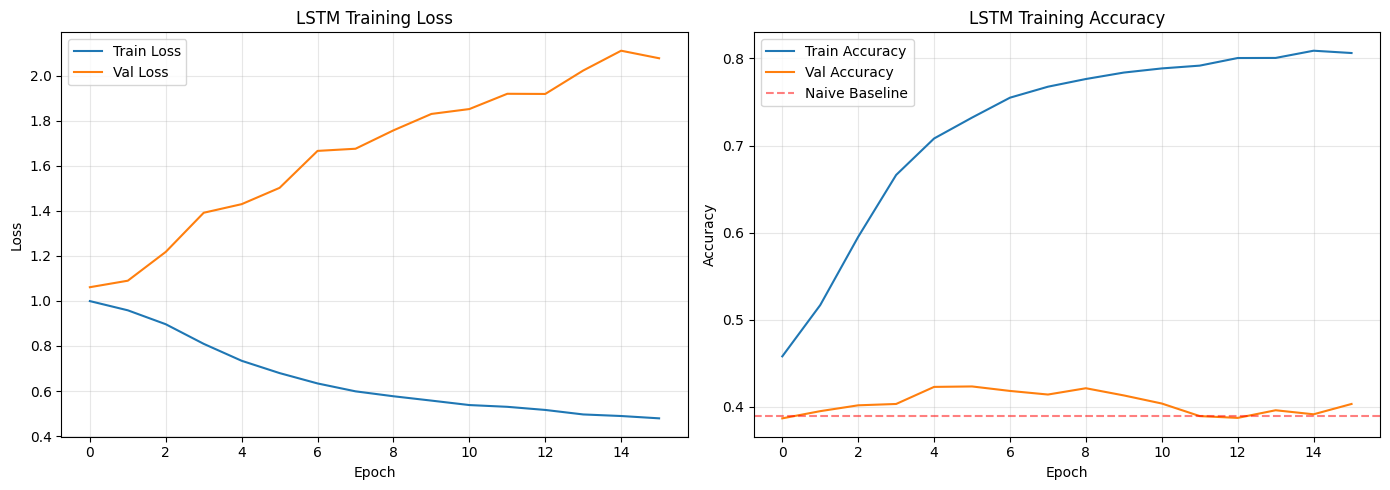

In [12]:
# Training curves for LSTM
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Training Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].axhline(baseline_acc, color='red', linestyle='--', label='Naive Baseline', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('LSTM Training Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

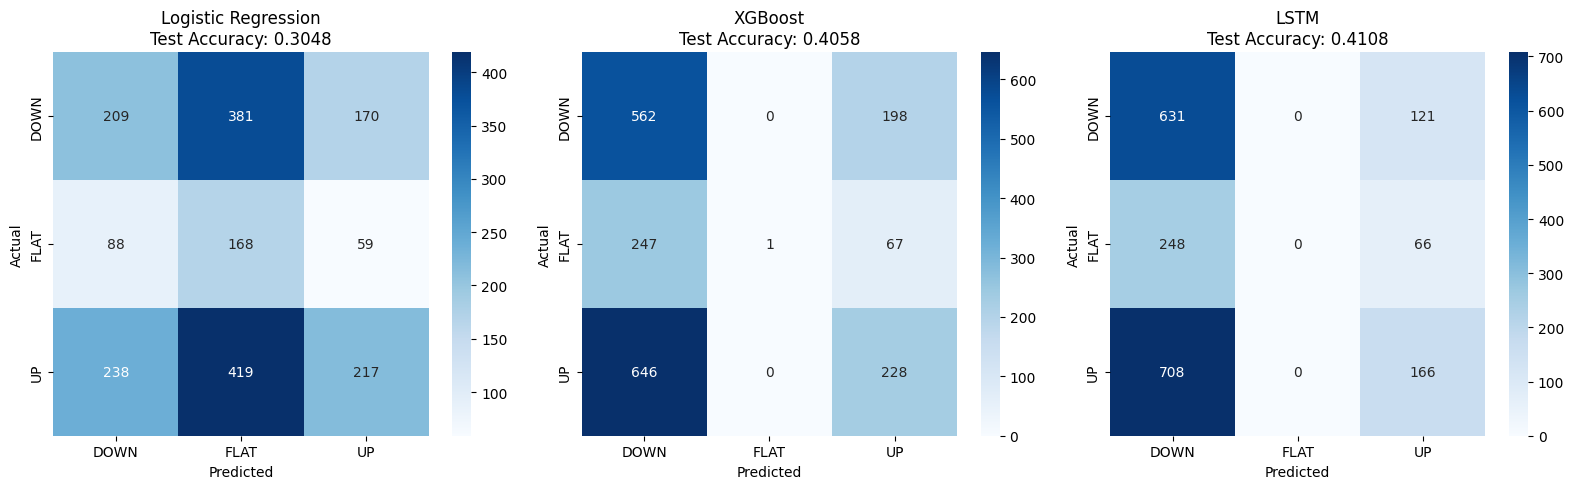

In [14]:
# Confusion matrices comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Compute accuracies for titles
accuracies = {
    'Logistic Regression': test_acc_lr,
    'XGBoost': test_acc_xgb,
    'LSTM': test_acc_lstm
}

for ax, cm, title in zip(axes, 
                         [cm_lr, cm_xgb, cm_lstm],
                         ['Logistic Regression', 'XGBoost', 'LSTM']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['DOWN', 'FLAT', 'UP'],
                yticklabels=['DOWN', 'FLAT', 'UP'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{title}\nTest Accuracy: {accuracies[title]:.4f}')

plt.tight_layout()
plt.show()

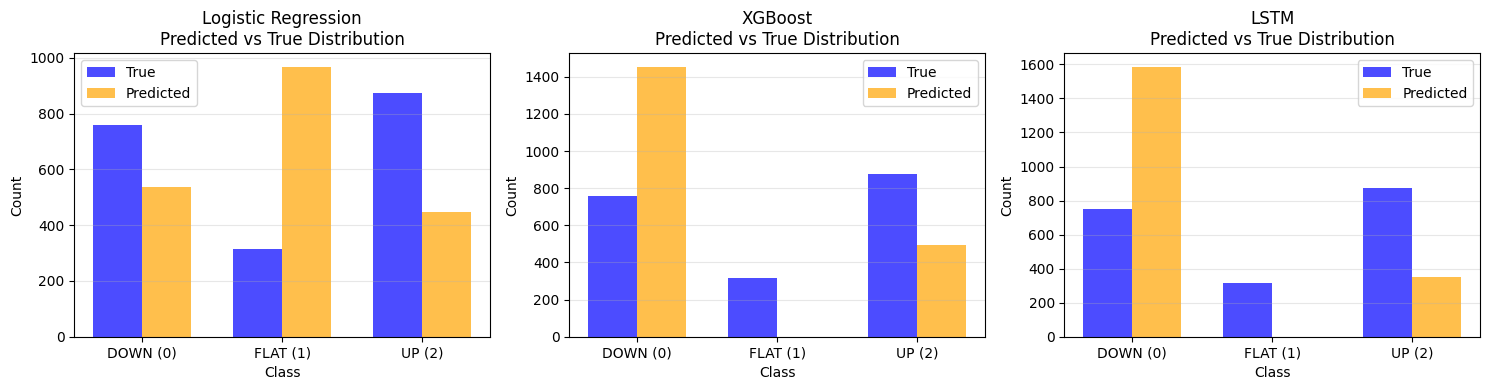

✓ Logistic Regression predicts all 3 classes (entropy: 1.0399)
✓ XGBoost predicts all 3 classes (entropy: 0.5698)
⚠️ WARNING: LSTM only predicts 2 classes: [0 2]


In [15]:
# Predicted class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_pred = [
    ('Logistic Regression', y_test_pred_lr),
    ('XGBoost', y_test_pred_xgb),
    ('LSTM', y_test_pred_lstm)
]

for ax, (model_name, y_pred) in zip(axes, models_pred):
    pred_counts = np.bincount(y_pred, minlength=3)
    true_counts = np.bincount(y_test if model_name != 'LSTM' else y_test_seq, minlength=3)
    
    x = np.arange(3)
    width = 0.35
    
    ax.bar(x - width/2, true_counts, width, label='True', alpha=0.7, color='blue')
    ax.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.7, color='orange')
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{model_name}\nPredicted vs True Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(['DOWN (0)', 'FLAT (1)', 'UP (2)'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Check if any model collapses to single class
for model_name, y_pred in models_pred:
    unique_preds = np.unique(y_pred)
    if len(unique_preds) < 3:
        print(f"⚠️ WARNING: {model_name} only predicts {len(unique_preds)} classes: {unique_preds}")
    else:
        pred_entropy = -sum((np.bincount(y_pred, minlength=3) / len(y_pred)) * 
                           np.log(np.bincount(y_pred, minlength=3) / len(y_pred) + 1e-8))
        print(f"✓ {model_name} predicts all 3 classes (entropy: {pred_entropy:.4f})")

## 9. Sample Predictions Inspection

Examine actual predictions on specific examples to verify sanity.

In [16]:
# Sample random test examples
print("="*80)
print("SAMPLE PREDICTION INSPECTION")
print("="*80)

np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=5, replace=False)

for i, idx in enumerate(sample_indices, 1):
    # Get original data index (accounting for sequence lookback)
    orig_idx = val_end + idx
    
    # Current state
    current_mid = df_valid.iloc[orig_idx]['midprice']
    current_spread = (df_valid.iloc[orig_idx]['ask_price_1'] - 
                     df_valid.iloc[orig_idx]['bid_price_1'])
    
    # Future state
    future_idx = orig_idx + HORIZON
    if future_idx < len(df_valid):
        future_mid = df_valid.iloc[future_idx]['midprice']
        actual_return = (future_mid - current_mid) / current_mid
    else:
        future_mid = np.nan
        actual_return = np.nan
    
    # True label
    true_label = y_test[idx]
    true_label_name = ['DOWN', 'FLAT', 'UP'][true_label]
    
    # Predictions
    lr_pred = y_test_pred_lr[idx]
    xgb_pred = y_test_pred_xgb[idx]
    
    # LSTM (need to find corresponding sequence index)
    seq_idx = idx - (val_end - val_end_seq)
    if 0 <= seq_idx < len(y_test_seq):
        lstm_pred = y_test_pred_lstm[seq_idx]
        lstm_probs = lstm_model.predict(X_test_seq[seq_idx:seq_idx+1], verbose=0)[0]
    else:
        lstm_pred = -1
        lstm_probs = [0, 0, 0]
    
    print(f"\n{'─'*80}")
    print(f"Sample {i}:")
    print(f"  Timestamp: {df_valid.iloc[orig_idx]['timestamp']}")
    print(f"  Current midprice: ${current_mid:.2f}")
    print(f"  Current spread: ${current_spread:.4f}")
    print(f"  Future midprice (H={HORIZON}): ${future_mid:.2f}")
    print(f"  Actual return: {actual_return*100:.3f}%")
    print(f"\n  True label: {true_label} ({true_label_name})")
    print(f"  Predictions:")
    print(f"    Logistic Regression: {lr_pred} ({['DOWN', 'FLAT', 'UP'][lr_pred]})")
    print(f"    XGBoost: {xgb_pred} ({['DOWN', 'FLAT', 'UP'][xgb_pred]})")
    if lstm_pred != -1:
        print(f"    LSTM: {lstm_pred} ({['DOWN', 'FLAT', 'UP'][lstm_pred]})")
        print(f"    LSTM probabilities: DOWN={lstm_probs[0]:.3f}, FLAT={lstm_probs[1]:.3f}, UP={lstm_probs[2]:.3f}")

print(f"\n{'='*80}")

SAMPLE PREDICTION INSPECTION

────────────────────────────────────────────────────────────────────────────────
Sample 1:
  Timestamp: 2025-11-26 21:41:33.502780
  Current midprice: $3025.97
  Current spread: $0.0100
  Future midprice (H=10): $3031.26
  Actual return: 0.174%

  True label: 2 (UP)
  Predictions:
    Logistic Regression: 1 (FLAT)
    XGBoost: 0 (DOWN)
    LSTM: 2 (UP)
    LSTM probabilities: DOWN=0.414, FLAT=0.109, UP=0.477

────────────────────────────────────────────────────────────────────────────────
Sample 2:
  Timestamp: 2025-11-26 18:11:03.391396
  Current midprice: $3034.10
  Current spread: $0.0100
  Future midprice (H=10): $3033.53
  Actual return: -0.019%

  True label: 1 (FLAT)
  Predictions:
    Logistic Regression: 0 (DOWN)
    XGBoost: 0 (DOWN)
    LSTM: 2 (UP)
    LSTM probabilities: DOWN=0.431, FLAT=0.132, UP=0.437

────────────────────────────────────────────────────────────────────────────────
Sample 3:
  Timestamp: 2025-11-26 10:56:56.483849
  Current 

## 10. Final Summary and Recommendations

In [ ]:
print("="*80)
print("FINAL PERFORMANCE SUMMARY")
print("="*80)

print(f"\nLabel Definition:")
print(f"  Horizon (H): {HORIZON} steps")
print(f"  Deadzone (ε): {DEADZONE:.4f} ({DEADZONE*100:.2f}%)")
print(f"  Classes: 0=DOWN, 1=FLAT, 2=UP")

print(f"\nDataset:")
print(f"  Total valid samples: {len(df_valid):,}")
print(f"  Train: {len(y_train):,}, Val: {len(y_val):,}, Test: {len(y_test):,}")
print(f"  Features: {X_train.shape[1]}")

print(f"\nTest Set Accuracy:")
print(f"  Naive baseline (majority class): {baseline_acc:.4f}")
print(f"  Logistic Regression:             {test_acc_lr:.4f}  (+{100*(test_acc_lr/baseline_acc - 1):>5.1f}%)")
print(f"  XGBoost:                         {test_acc_xgb:.4f}  (+{100*(test_acc_xgb/baseline_acc - 1):>5.1f}%)")
print(f"  LSTM:                            {test_acc_lstm:.4f}  (+{100*(test_acc_lstm/baseline_acc - 1):>5.1f}%)")

print(f"\n{'='*80}")
print("CONCLUSIONS")
print("="*80)

best_model = max([('Logistic Regression', test_acc_lr),
                  ('XGBoost', test_acc_xgb),
                  ('LSTM', test_acc_lstm)],
                 key=lambda x: x[1])

print(f"\nBest performing model: {best_model[0]} (accuracy: {best_model[1]:.4f})")

if best_model[1] > baseline_acc + 0.05:
    print("✓ Models show meaningful improvement over baseline")
else:
    print("⚠️ Models struggle to beat baseline significantly")
    print("\nPossible reasons:")
    print("  1. Horizon H too long or deadzone ε too small (signal is noisy)")
    print("  2. L2 orderbook features don't capture midprice dynamics well")
    print("  3. Need more data or different features (e.g., trade flow, time of day)")

print(f"\nRecommendations:")
print(f"  - Current H={HORIZON}, ε={DEADZONE:.4f} ({DEADZONE*100:.2f}%)")
print(f"  - Try shorter horizons: H=5 or H=3")
print(f"  - Try larger deadzones: ε=0.001 (0.1%) or ε=0.002 (0.2%)")
print(f"  - Add more features: volume-weighted prices, order arrival rates, time features")
print(f"  - Consider regime-specific models (high vs low volatility)")

print(f"\n{'='*80}")
print("✓ Analysis complete!")